In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

shape of moons:  (10000, 2)


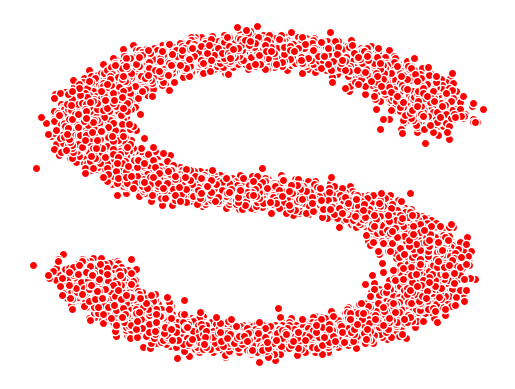

In [2]:
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0

print("shape of moons: ", np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolors='white')

ax.axis('off')

dataset = torch.Tensor(s_curve).float()

## 2. 确定超参数的值

In [3]:
num_steps = 100 # 对于步骤，一开始可以由beta、分布的均值和标准差来共同确定

# 制作每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

# 计算alpha、 alpha_prod、 alpha_prod_previous、 alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0) # previous

alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alpha_bar_log = torch.log(1 - alphas_prod)
one_minus_alpha_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == alphas_bar_sqrt.shape == one_minus_alpha_bar_log.shape == one_minus_alpha_bar_sqrt.shape

print("all the same shape: ", betas.shape)

all the same shape:  torch.Size([100])


## 3. 确定扩散过程中任意时刻的采样值

$$
X_t = \sqrt{\alpha_t} X_{t-1} + \sqrt{1-\alpha_t} Z_{t-1} \\
= \sqrt{\widehat{\alpha_t}} X_0 + \sqrt{1-\widehat{\alpha_t}}Z
$$

In [4]:
def q_x(x_0, t):
    noise = torch.randn_like(x_0) # noise是从正态分布中生成的随机噪声
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alpha_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_l_m_t * noise) # 在x_0的基础上添加噪声

## 4. 原始数据分布加噪100步之后的结果

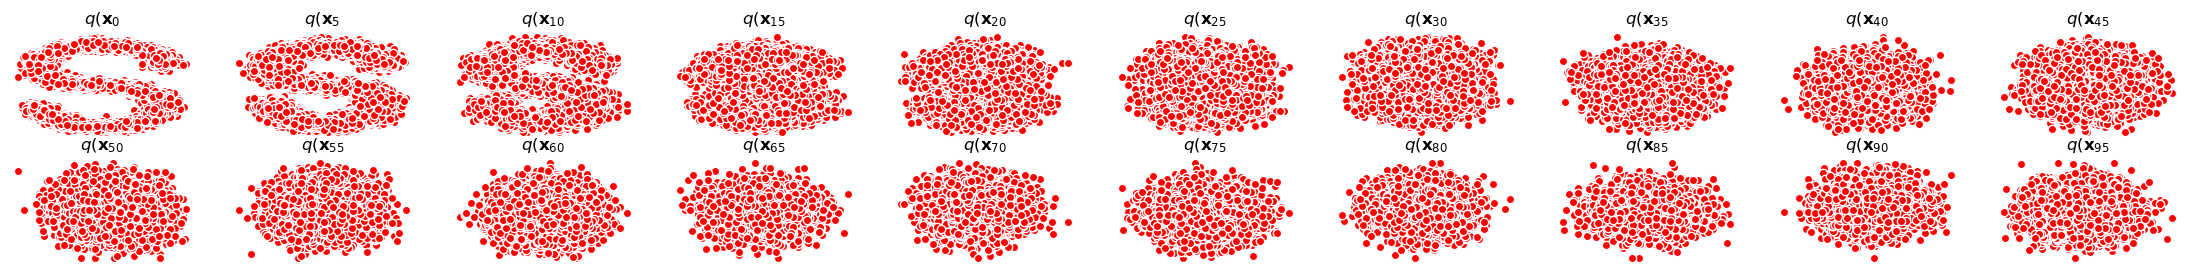

In [5]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

# 共有10000个点，每个点包含两个坐标
# 生成100步以内每5步后加噪的图像
for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps//num_shows])) # 生成t时刻的采样数据源
    axs[j, k].scatter(q_i[:, 0], q_i[:, 1], color='red', edgecolors='white')
    
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i*num_steps // num_shows)+'})$') # i * 5 0~95 step-5

## 5. 拟合逆扩散过程高斯分布的模型

In [10]:
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
        
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        return x

## 6. 误差函数

In [11]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alpha_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    
    # 随机采样一个时刻t
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0) # [batch_size, 1]
    t = t.unsqueeze(-1) # [batch_size]
    
    # x_0的系数
    a = alphas_bar_sqrt[t]
    
    # eps的系数
    am1 = one_minus_alpha_bar_sqrt[t]
    
    # 随即生成的噪音eps
    e = torch.randn_like(x_0)
    
    # 构造模型的输入
    x = x_0 * a + e * am1
    
    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))
    
    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

## 7. Inference 逆扩散采样函数

In [12]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alpha_bar_sqrt):
    """从X[T]中恢复 X[T-1] ... X[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,  betas, one_minus_alpha_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq


def p_sample(model, x, t, betas, one_minus_alpha_bar_sqrt):
    """从X[T]中采样t时刻的重构值"""
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alpha_bar_sqrt[t]
    
    eps_theta = model(x, t)
    
    mean = (1 - (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

## 8. Training

Training model...
tensor(0.5072, grad_fn=<MeanBackward0>)
tensor(0.3486, grad_fn=<MeanBackward0>)
tensor(0.4462, grad_fn=<MeanBackward0>)
tensor(0.3815, grad_fn=<MeanBackward0>)
tensor(0.2558, grad_fn=<MeanBackward0>)
tensor(0.4735, grad_fn=<MeanBackward0>)
tensor(0.5546, grad_fn=<MeanBackward0>)
tensor(0.2836, grad_fn=<MeanBackward0>)
tensor(0.1681, grad_fn=<MeanBackward0>)
tensor(0.3114, grad_fn=<MeanBackward0>)
tensor(0.1792, grad_fn=<MeanBackward0>)
tensor(0.1085, grad_fn=<MeanBackward0>)
tensor(0.2220, grad_fn=<MeanBackward0>)
tensor(0.2605, grad_fn=<MeanBackward0>)
tensor(0.3822, grad_fn=<MeanBackward0>)
tensor(0.2264, grad_fn=<MeanBackward0>)
tensor(0.3567, grad_fn=<MeanBackward0>)
tensor(0.2449, grad_fn=<MeanBackward0>)
tensor(0.3792, grad_fn=<MeanBackward0>)
tensor(0.2187, grad_fn=<MeanBackward0>)
tensor(0.4863, grad_fn=<MeanBackward0>)


C:\Users\Zhou7\AppData\Local\Temp\ipykernel_10424\3309639995.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


tensor(0.1993, grad_fn=<MeanBackward0>)
tensor(0.1415, grad_fn=<MeanBackward0>)
tensor(0.4649, grad_fn=<MeanBackward0>)
tensor(0.5301, grad_fn=<MeanBackward0>)
tensor(0.1717, grad_fn=<MeanBackward0>)
tensor(0.5618, grad_fn=<MeanBackward0>)
tensor(0.3725, grad_fn=<MeanBackward0>)
tensor(0.4787, grad_fn=<MeanBackward0>)
tensor(0.4715, grad_fn=<MeanBackward0>)
tensor(0.6338, grad_fn=<MeanBackward0>)
tensor(0.2128, grad_fn=<MeanBackward0>)
tensor(0.2156, grad_fn=<MeanBackward0>)
tensor(0.4318, grad_fn=<MeanBackward0>)
tensor(0.2276, grad_fn=<MeanBackward0>)
tensor(0.2321, grad_fn=<MeanBackward0>)
tensor(0.2193, grad_fn=<MeanBackward0>)
tensor(0.2520, grad_fn=<MeanBackward0>)
tensor(0.2416, grad_fn=<MeanBackward0>)
tensor(0.3385, grad_fn=<MeanBackward0>)


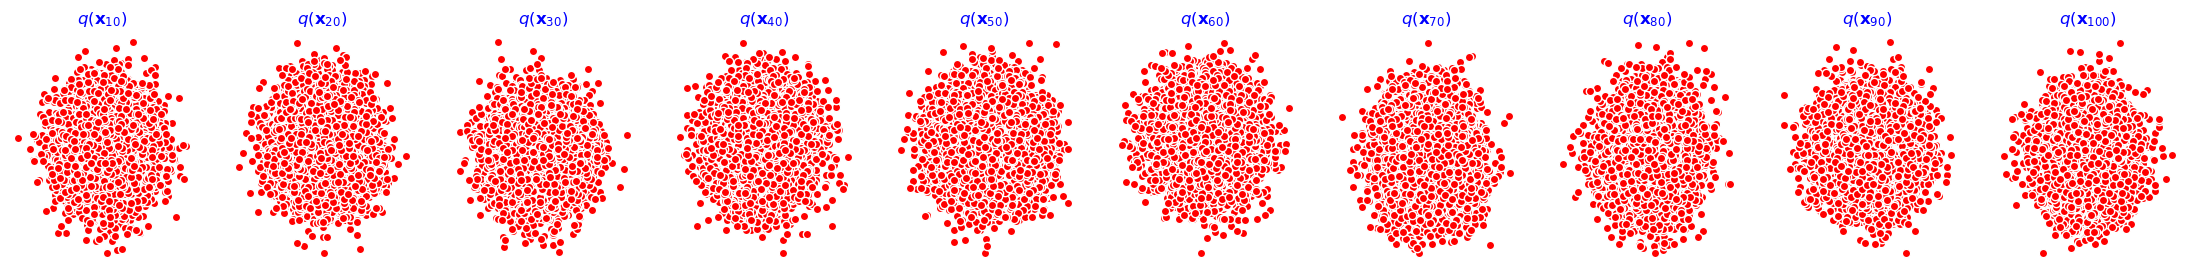

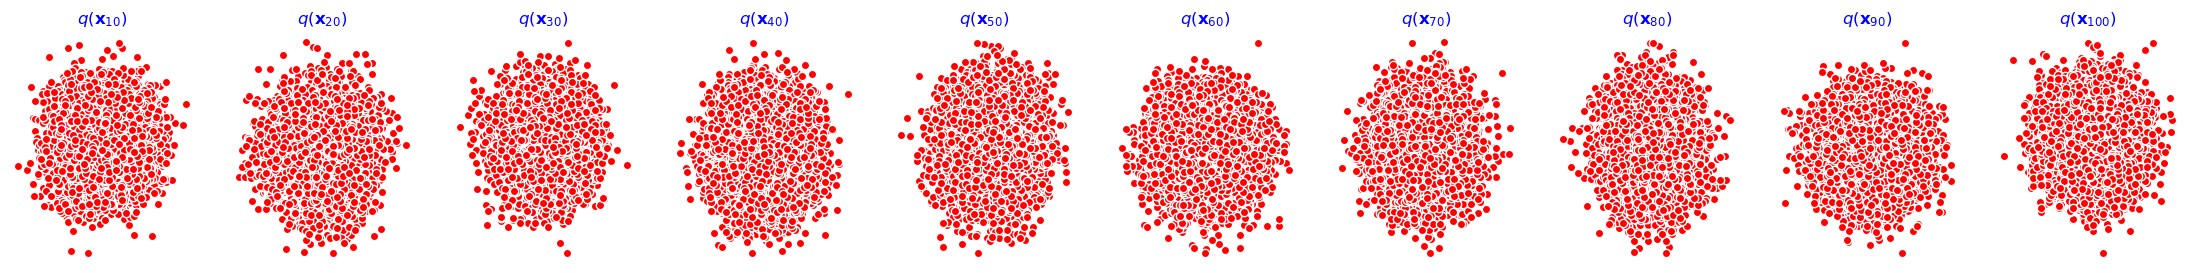

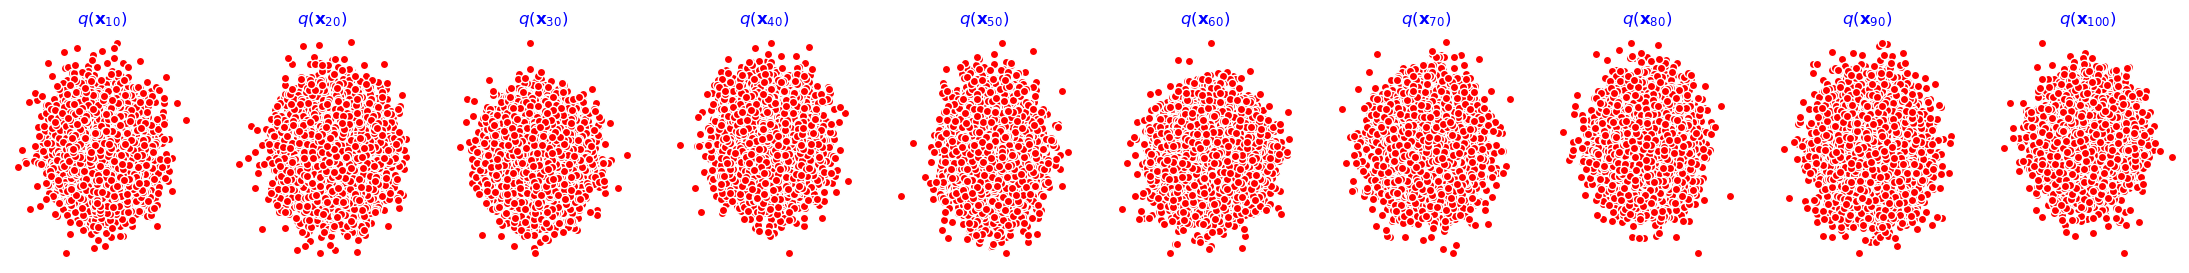

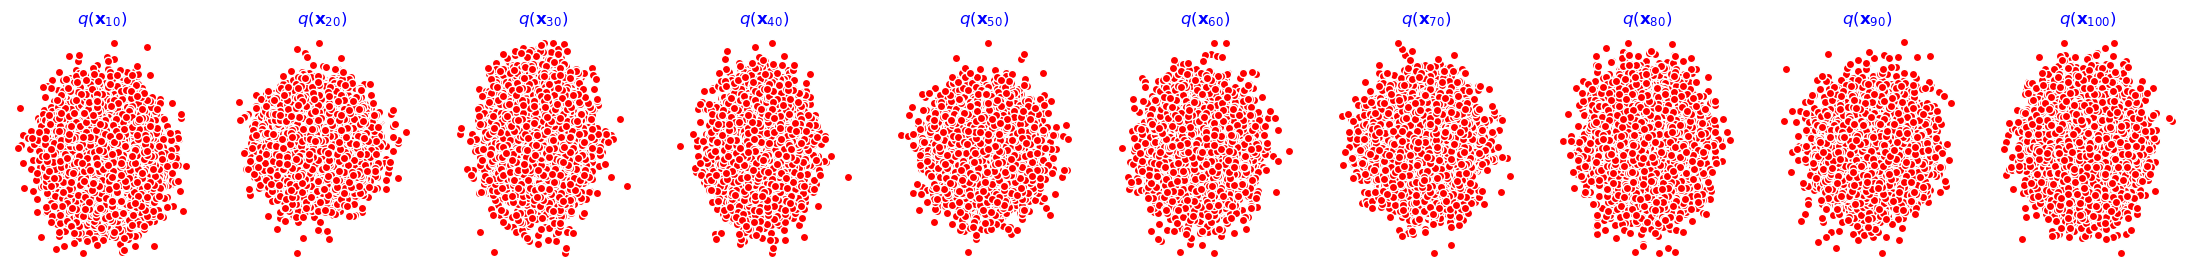

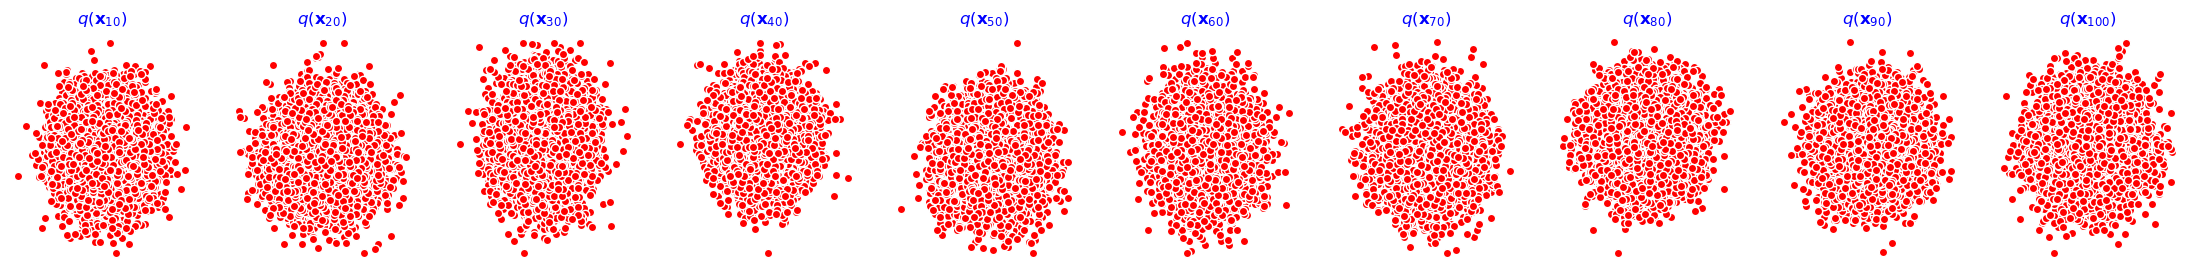

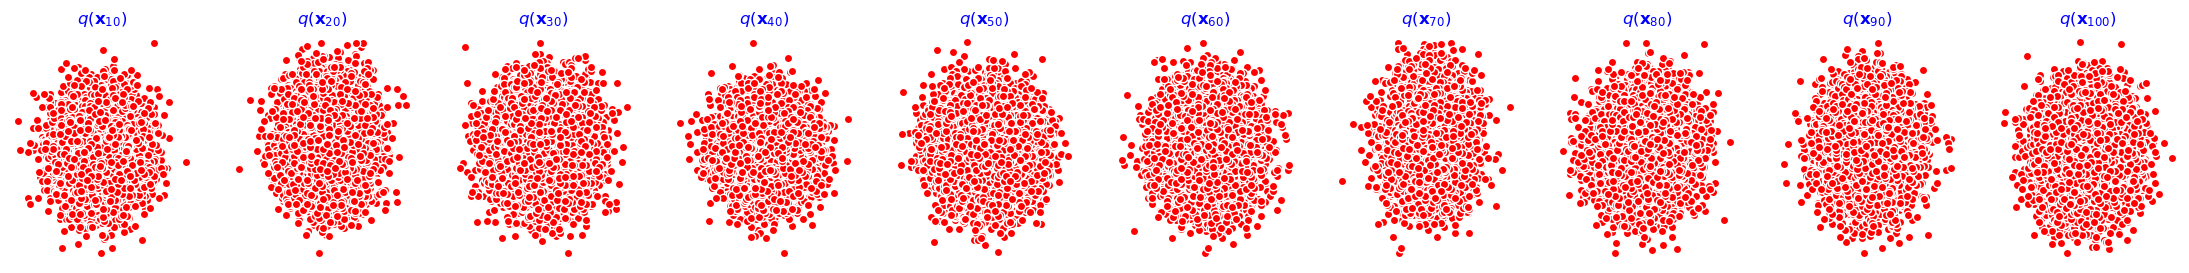

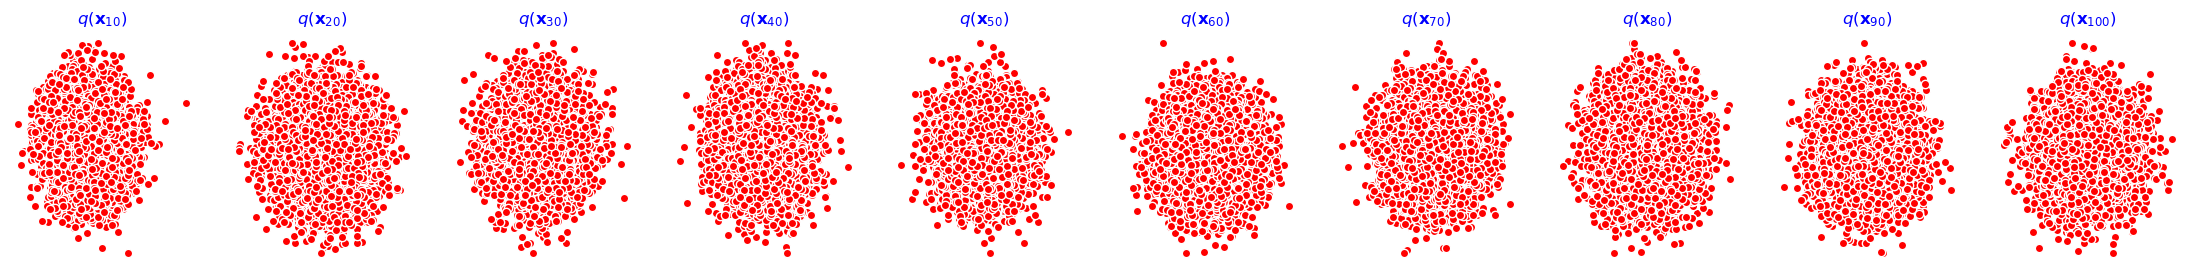

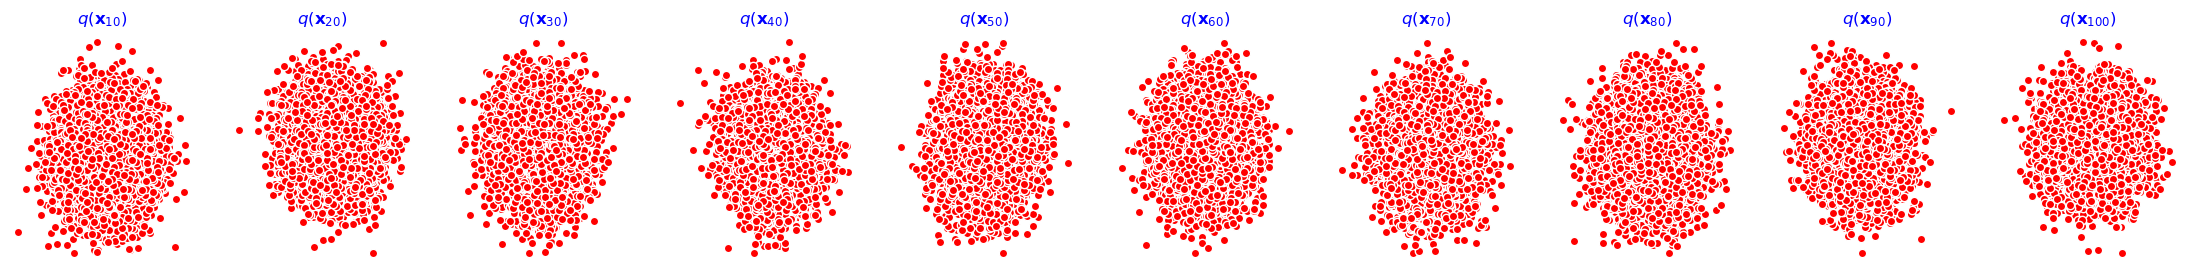

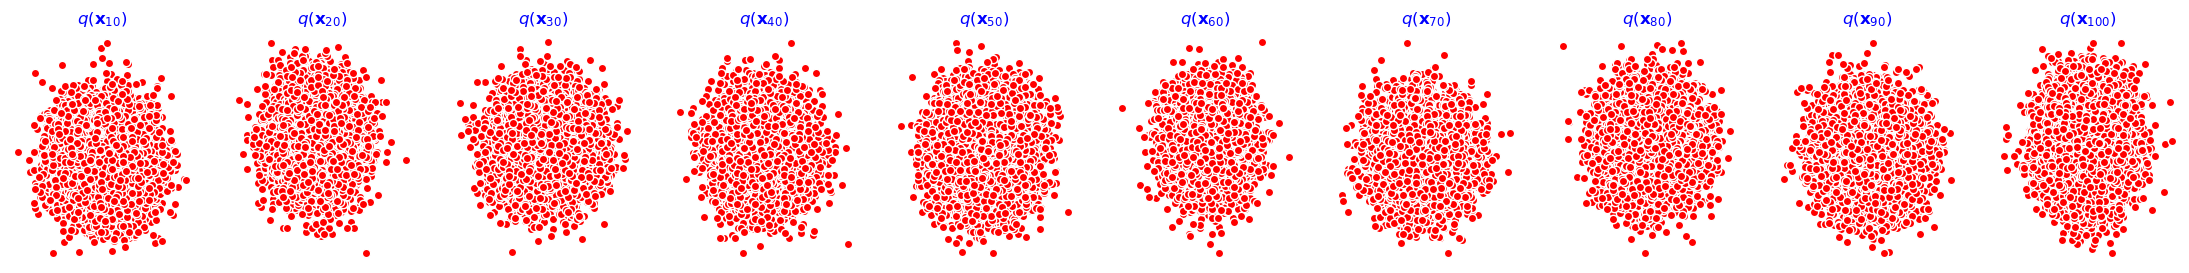

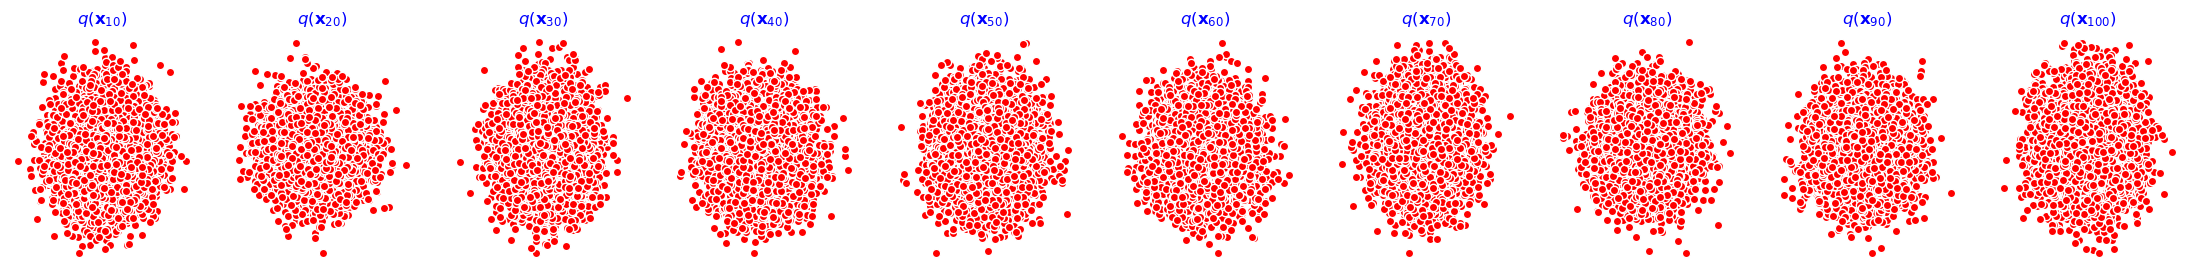

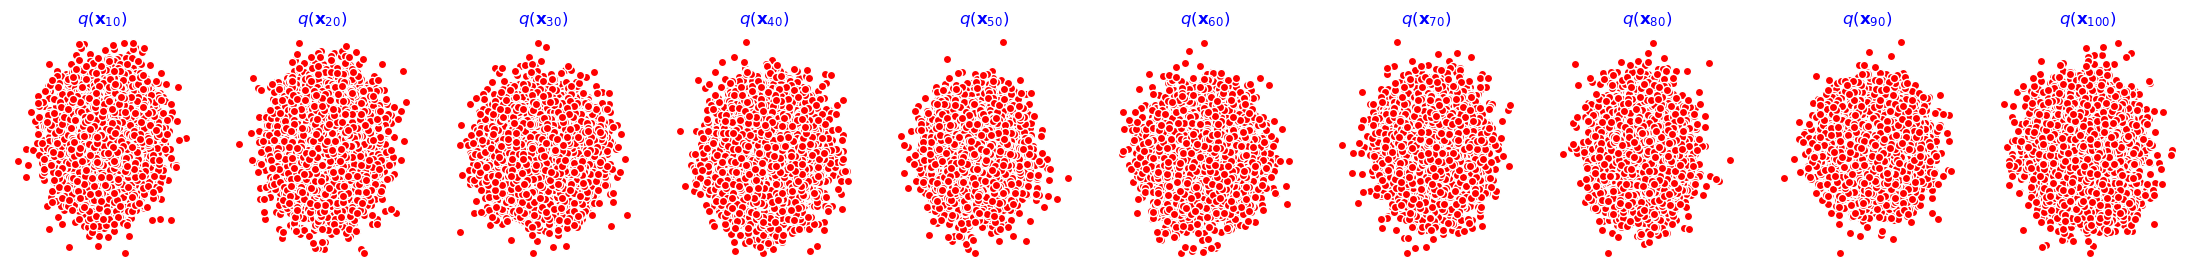

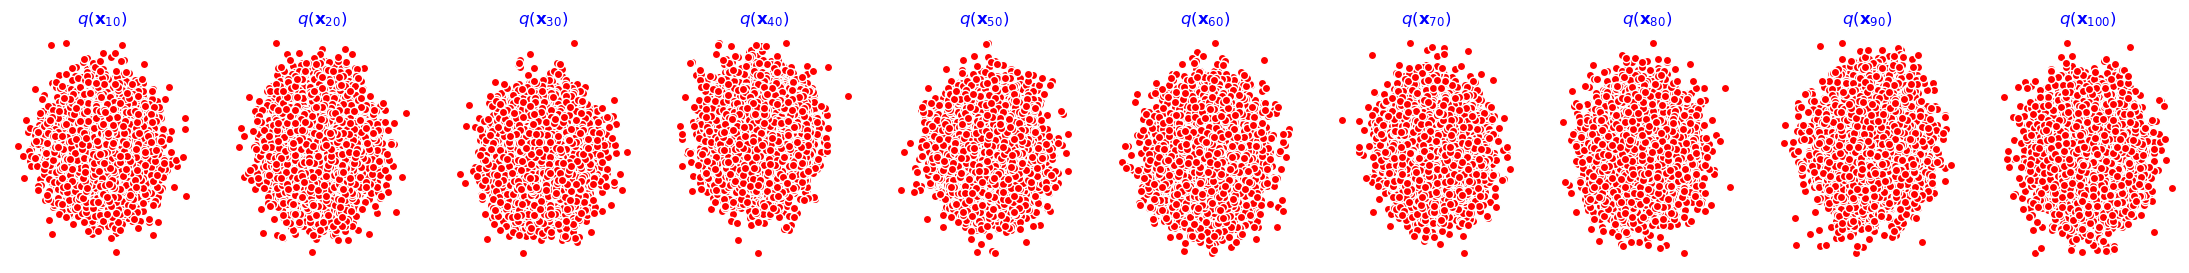

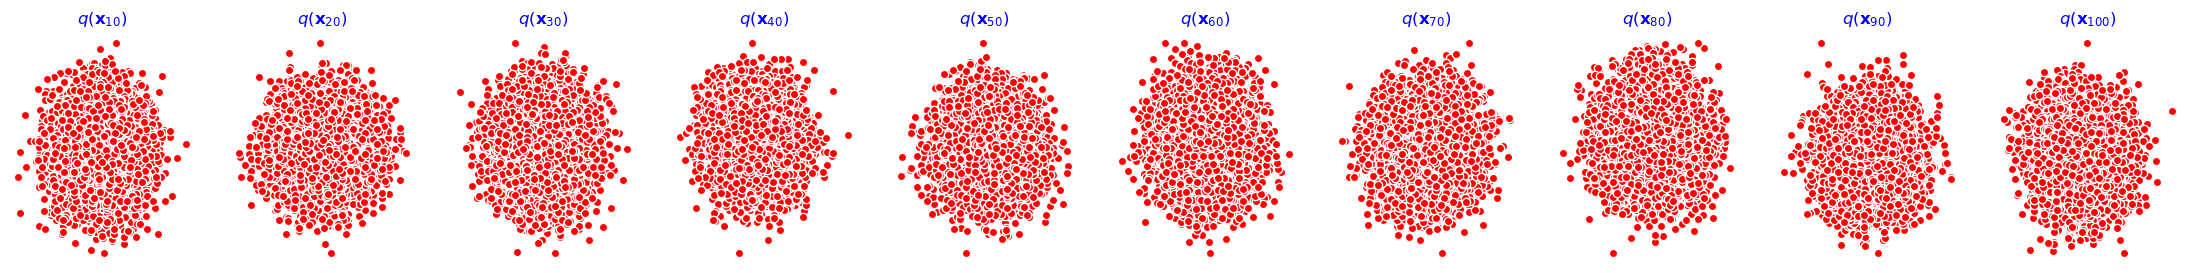

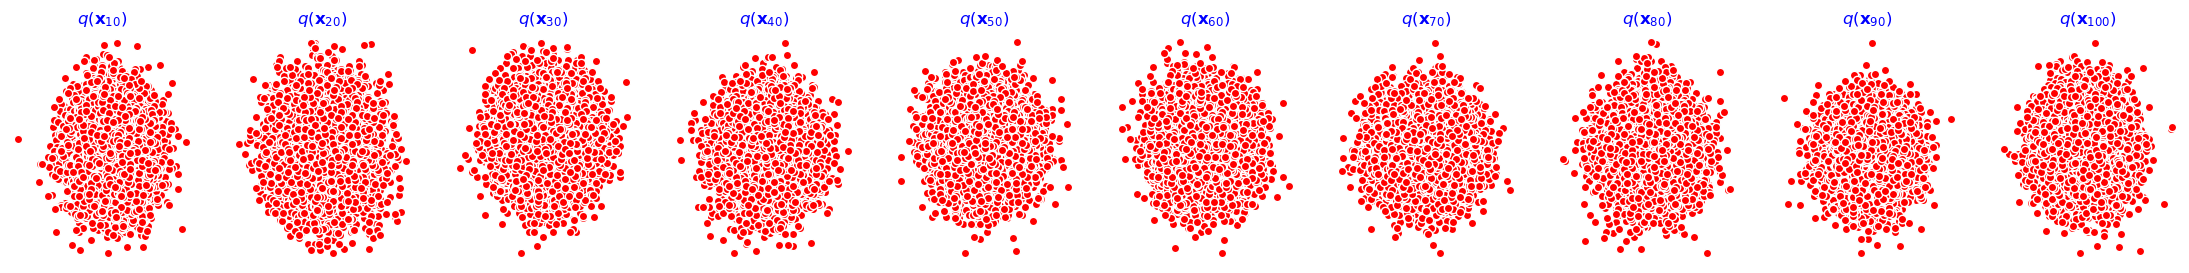

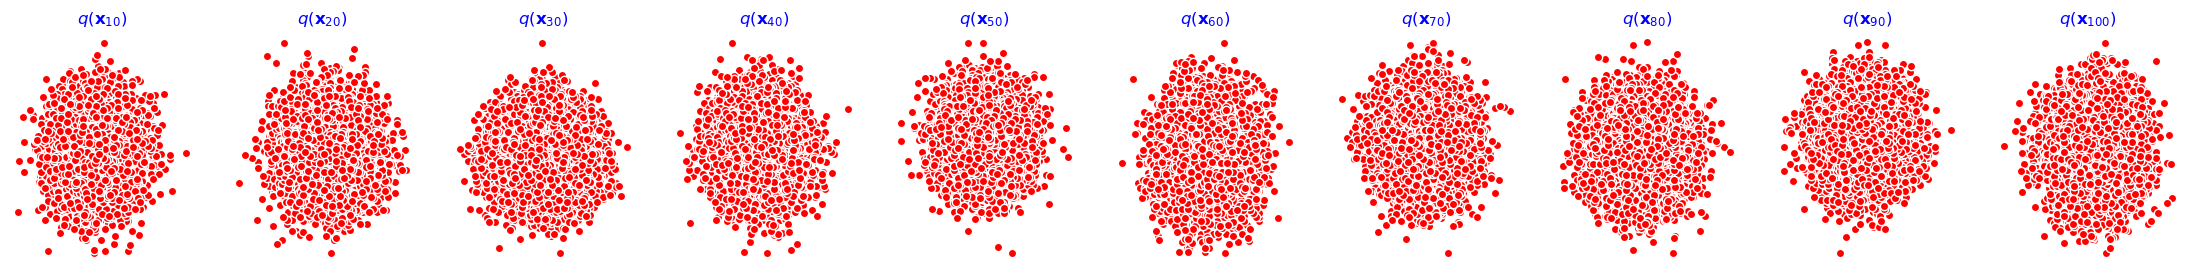

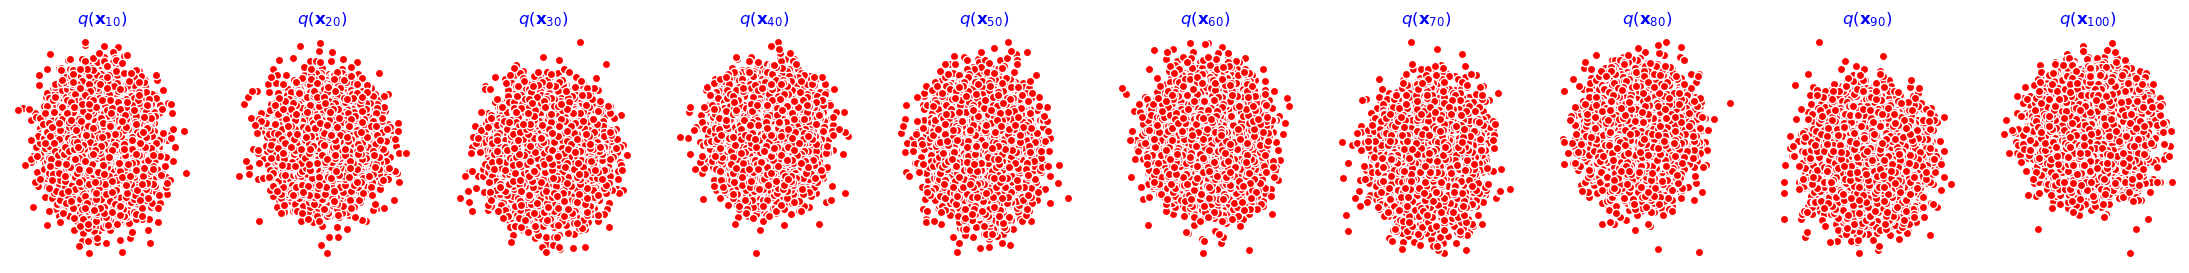

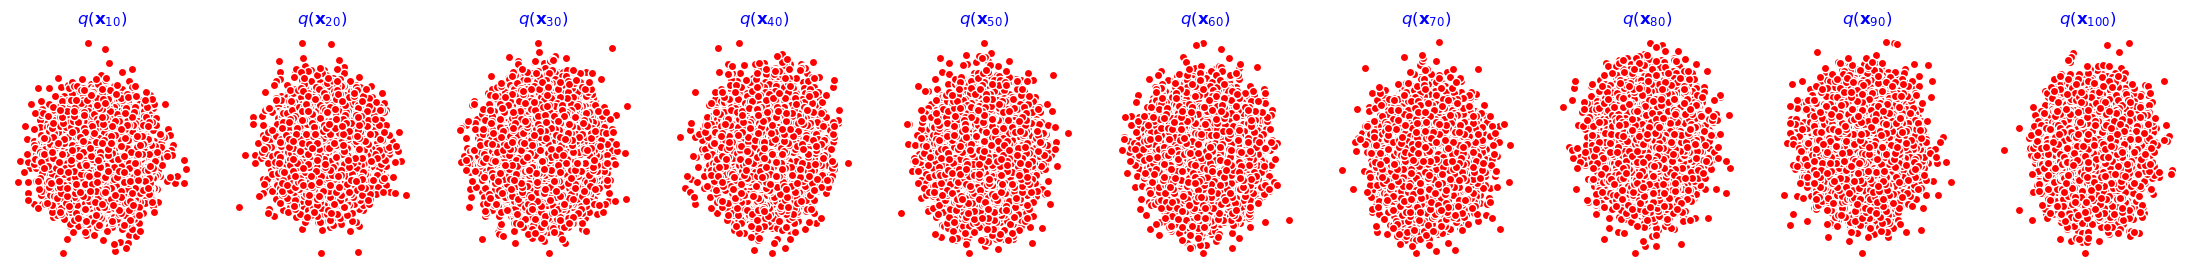

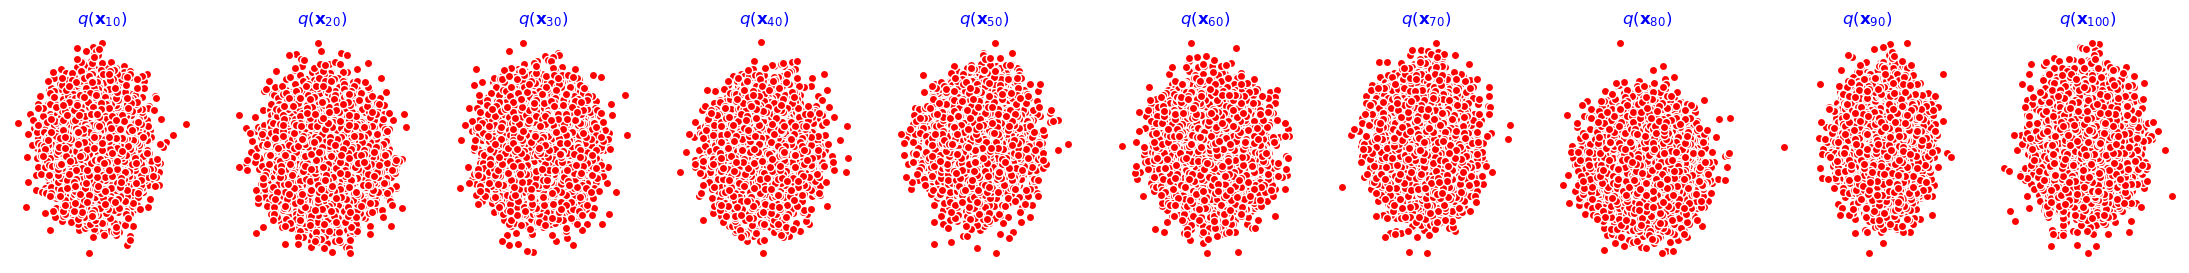

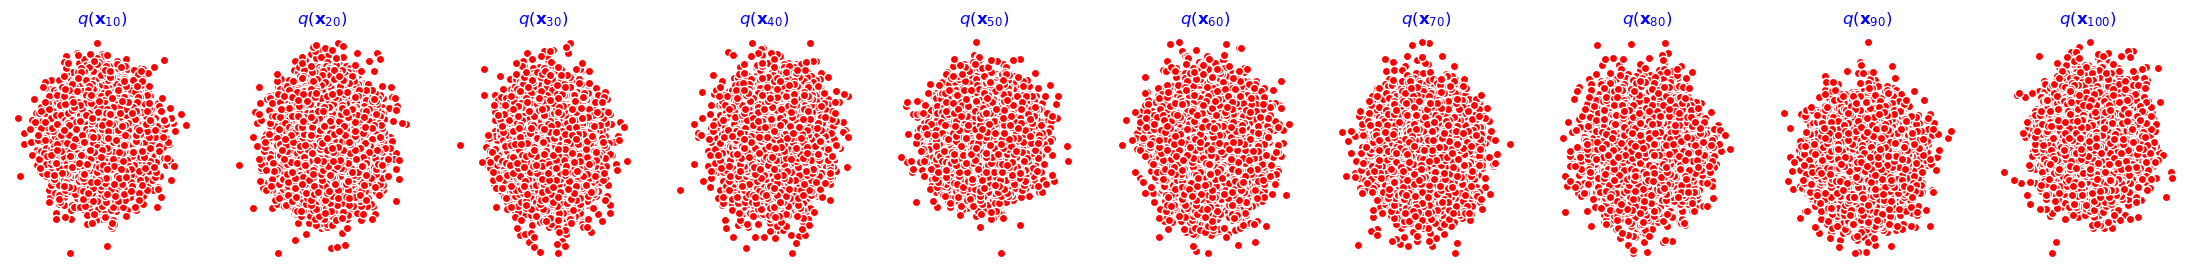

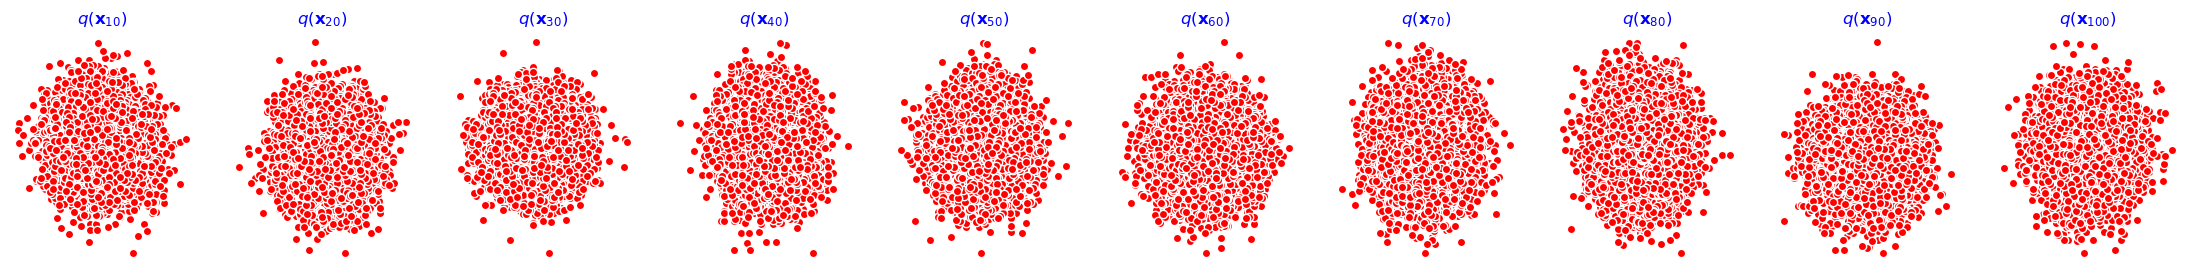

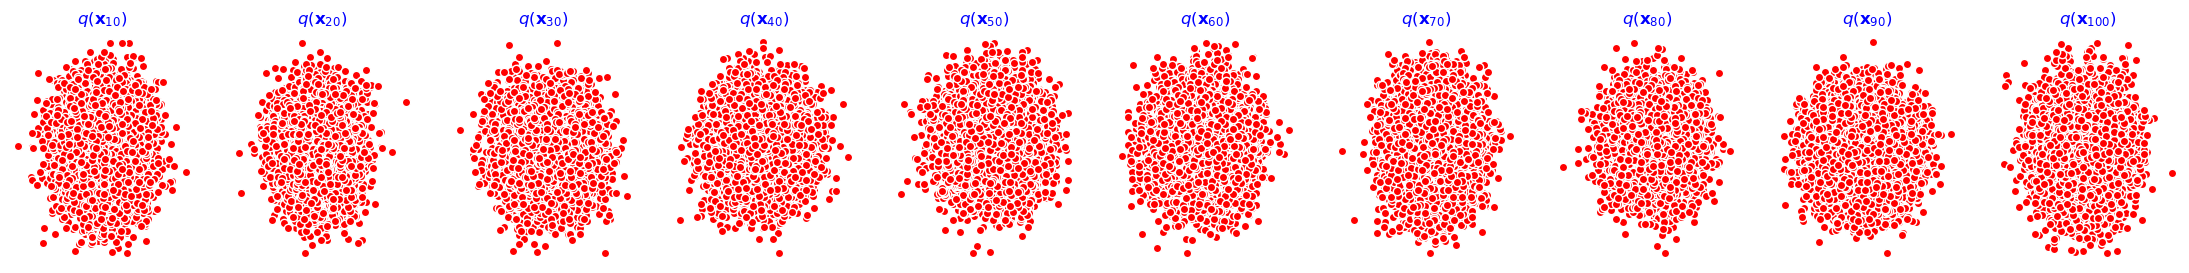

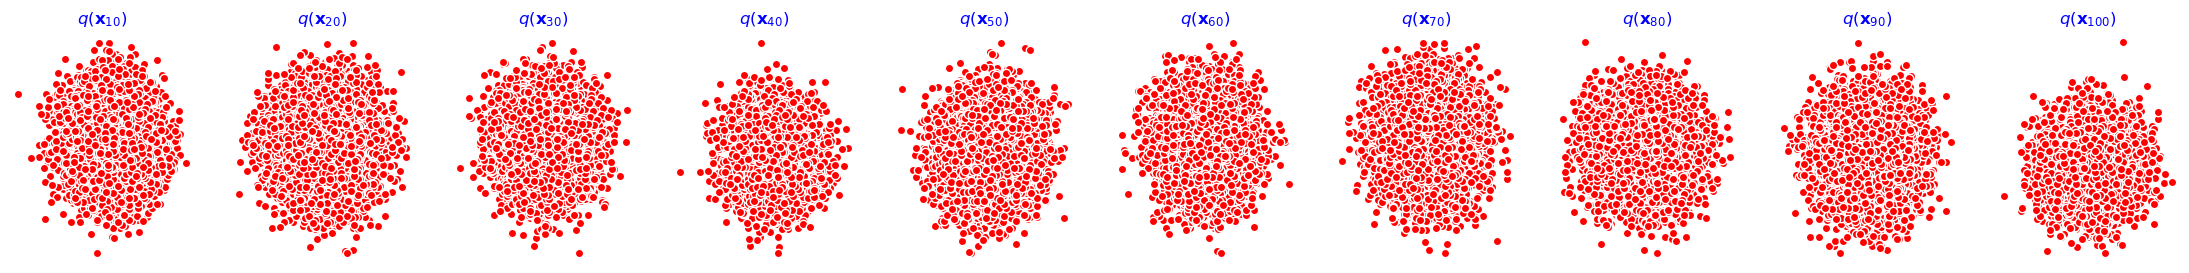

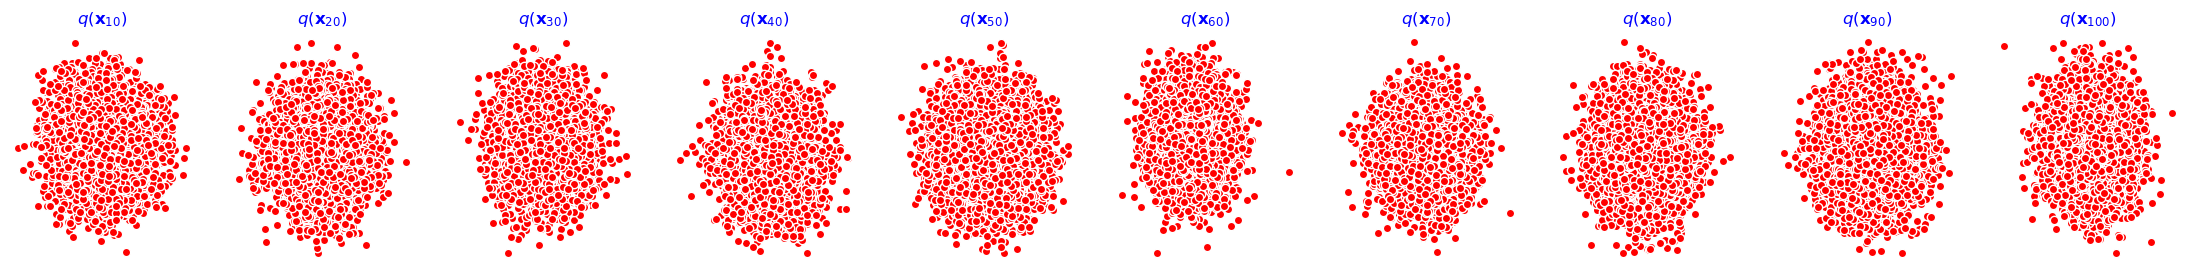

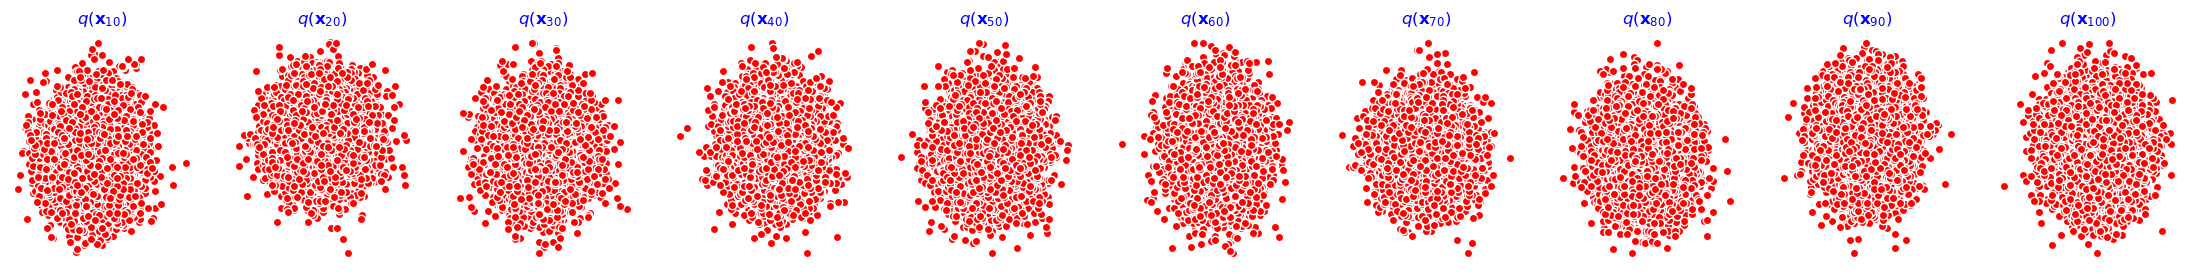

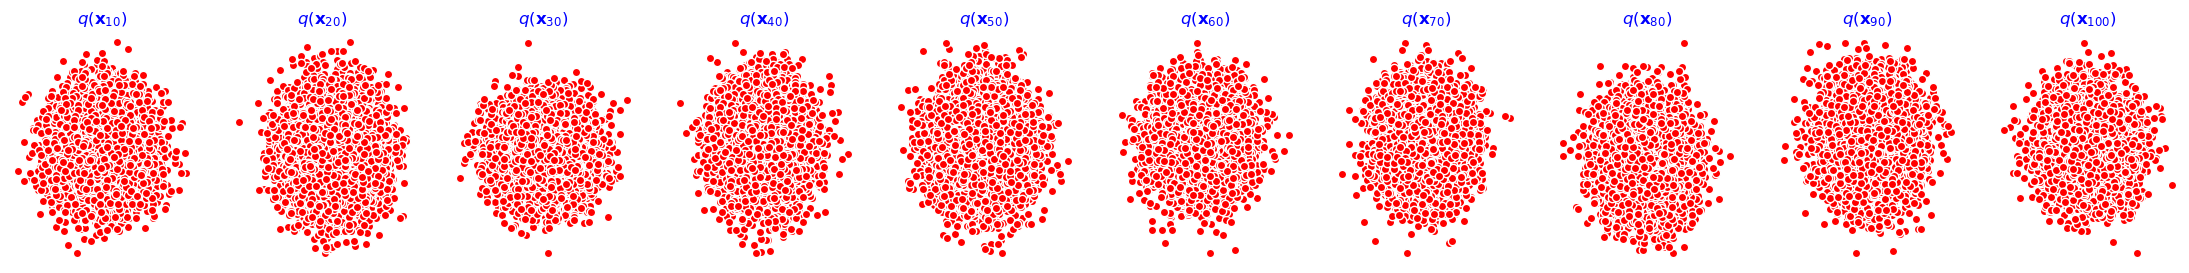

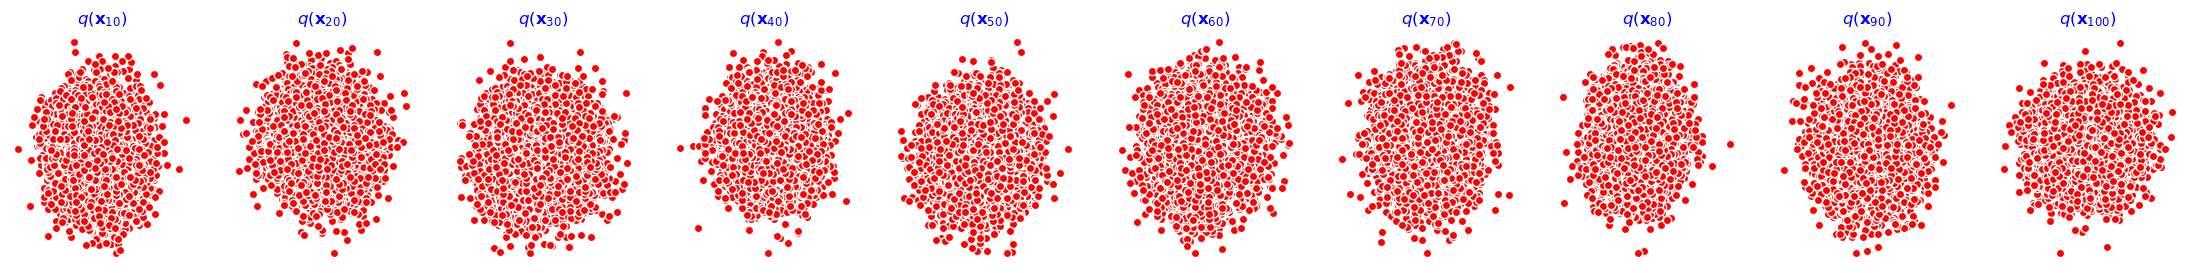

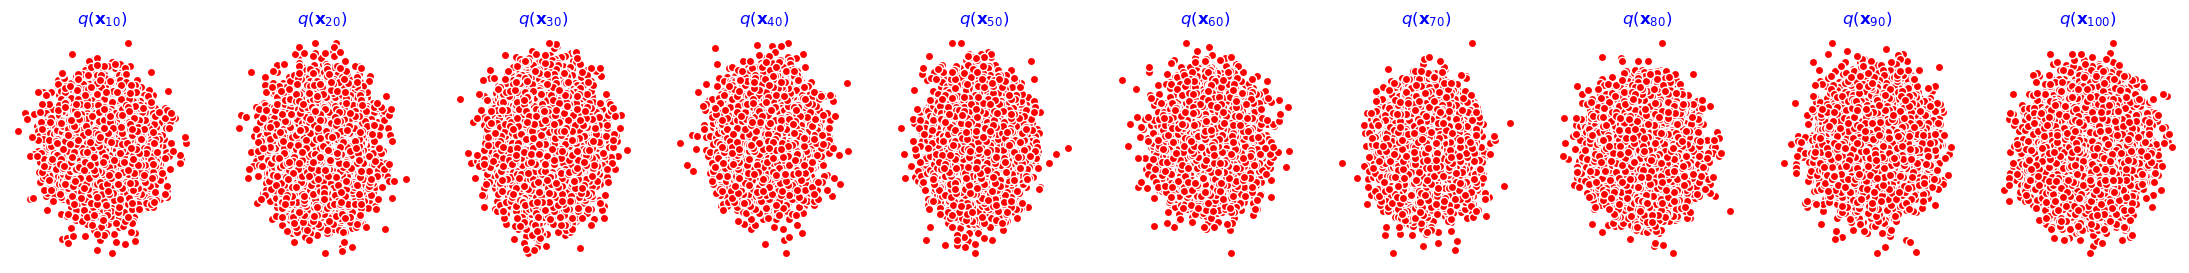

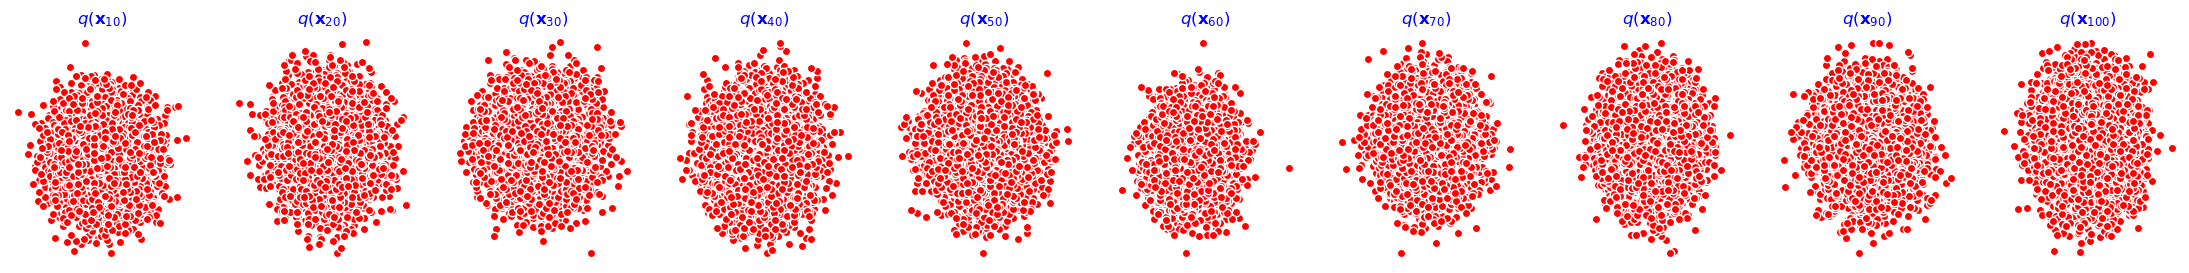

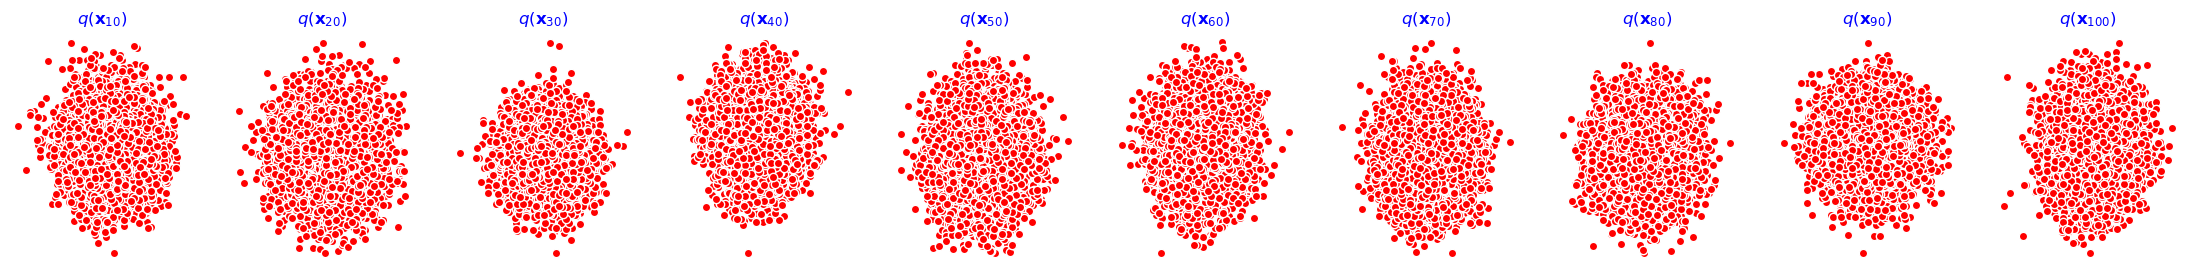

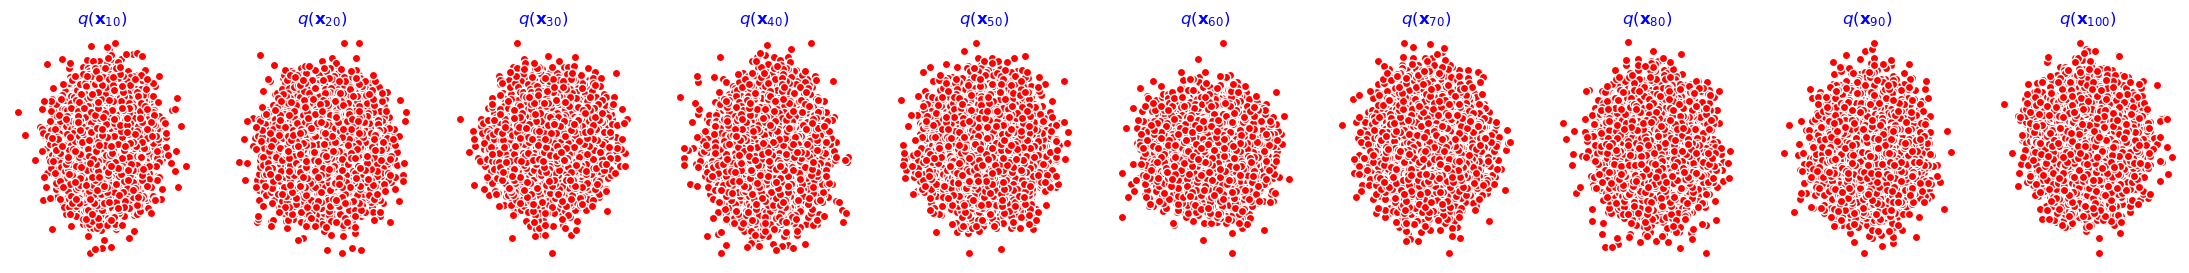

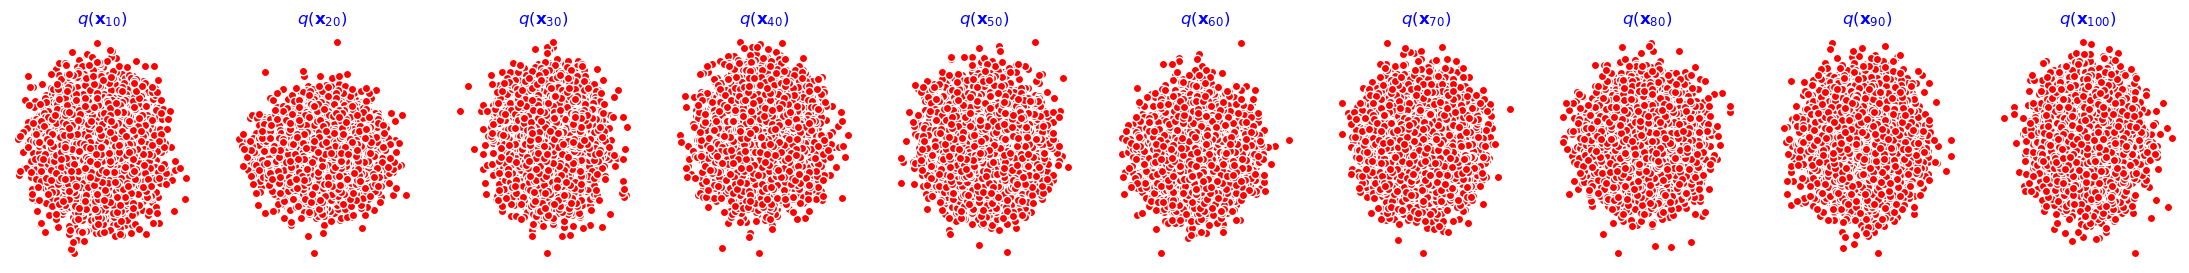

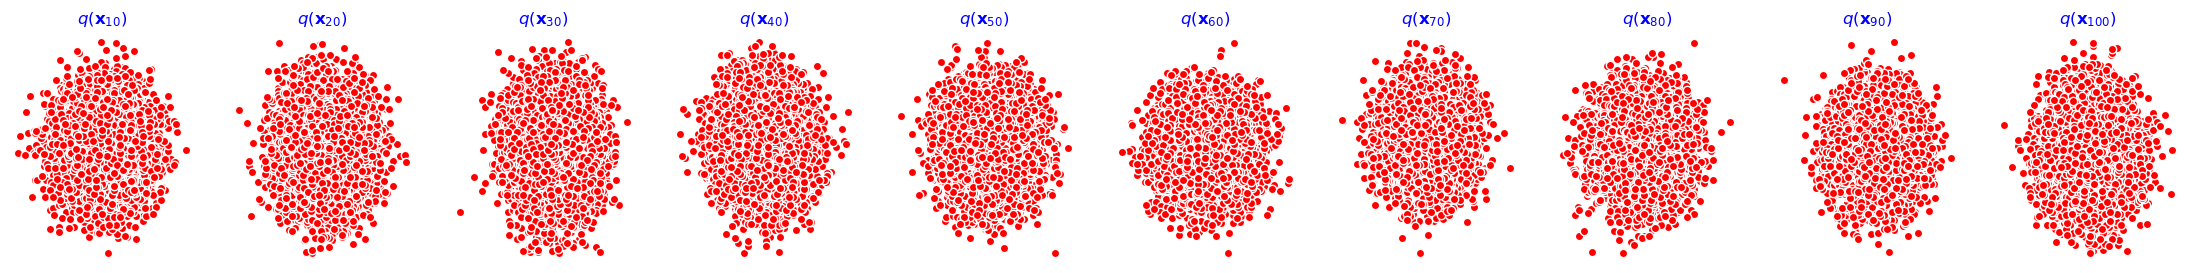

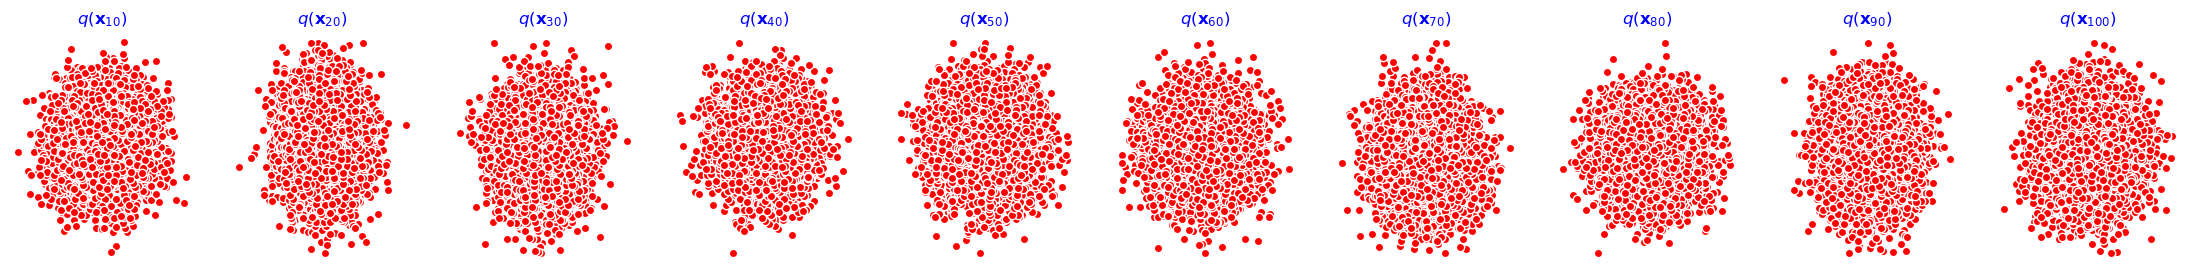

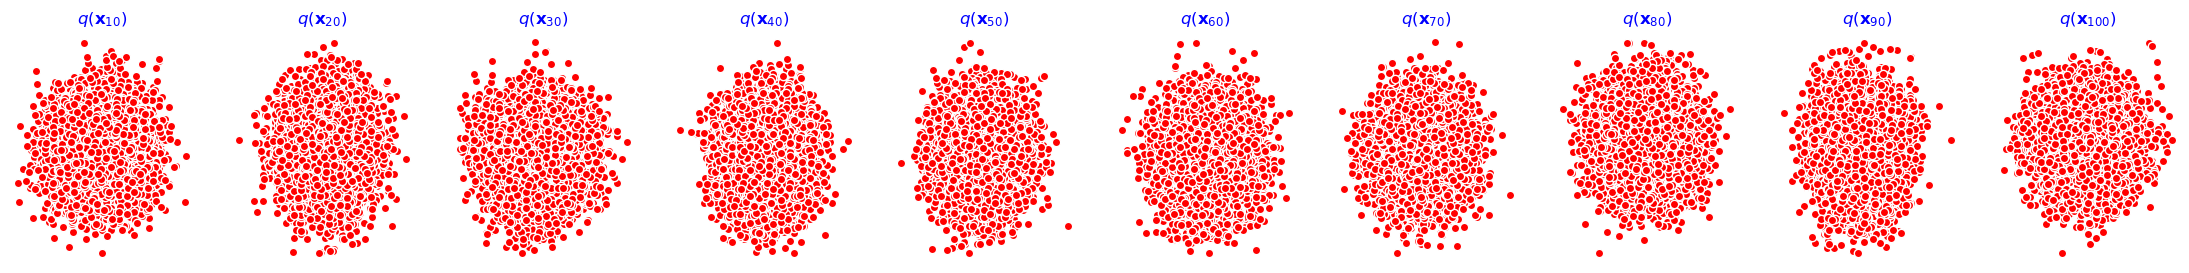

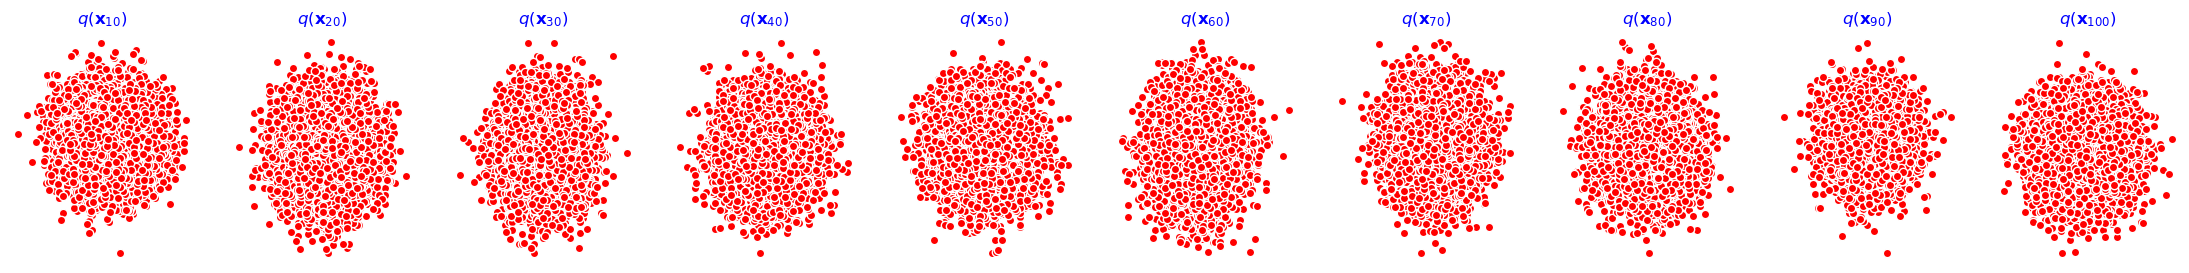

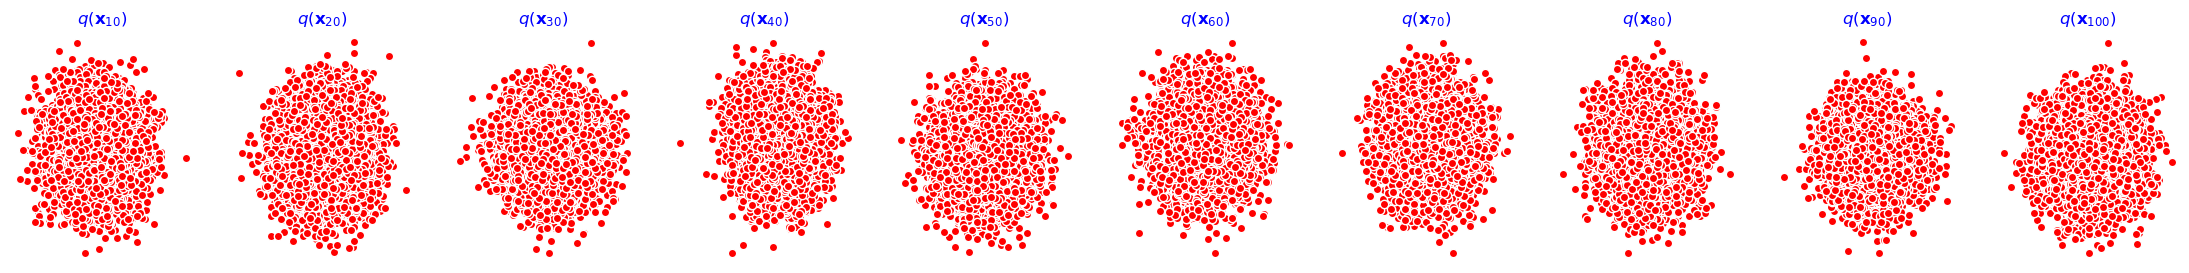

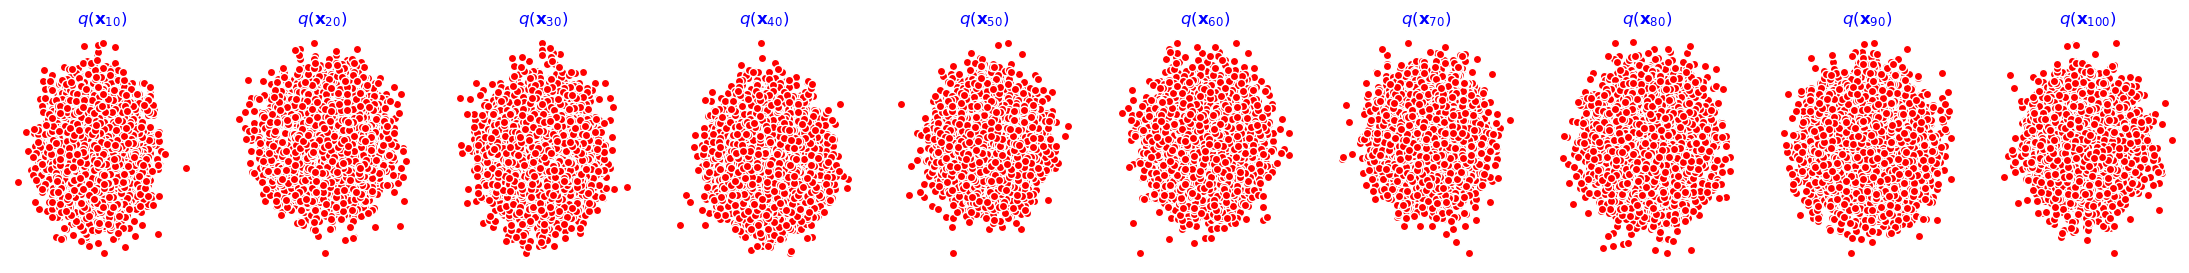

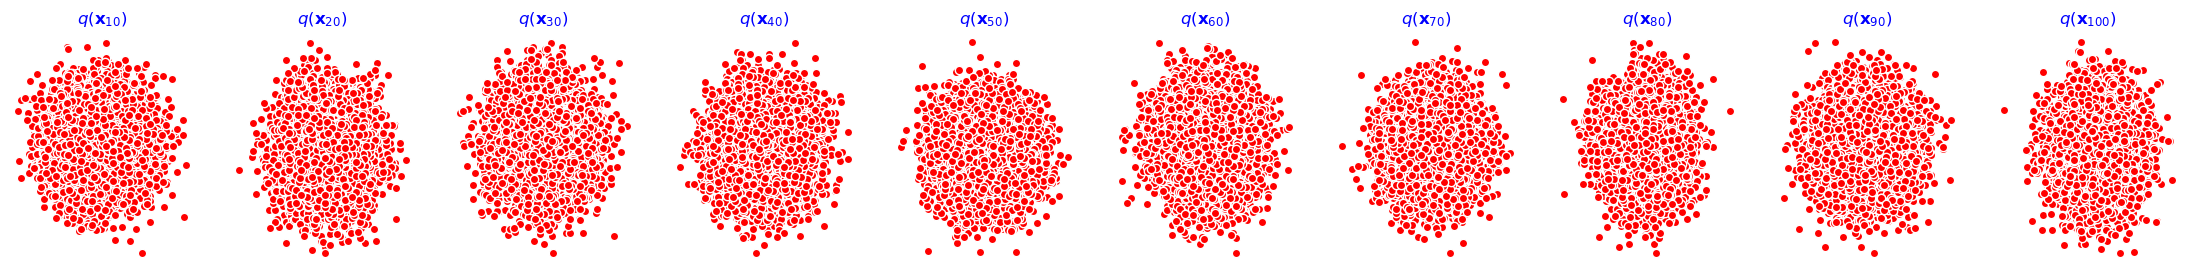

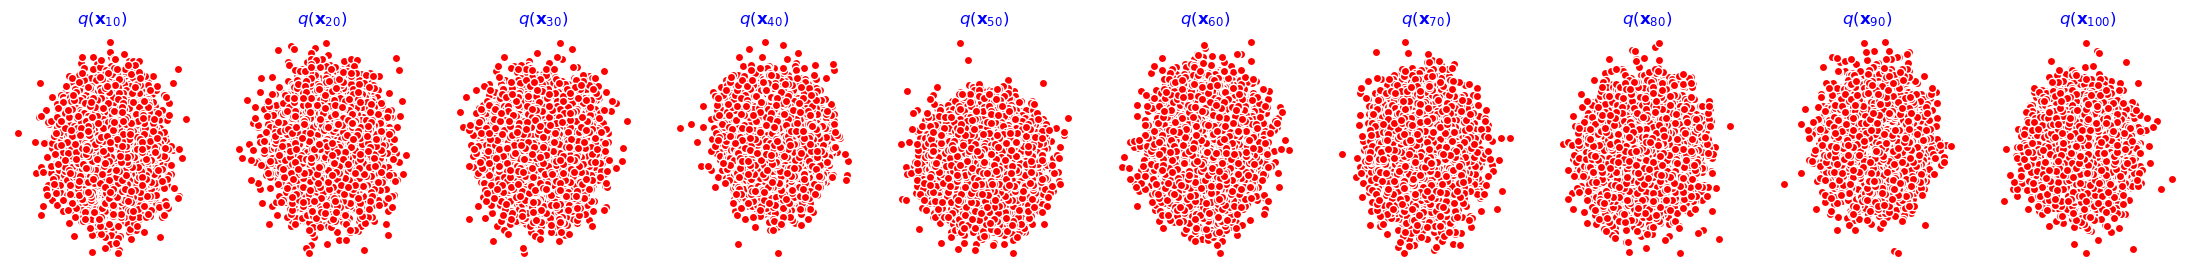

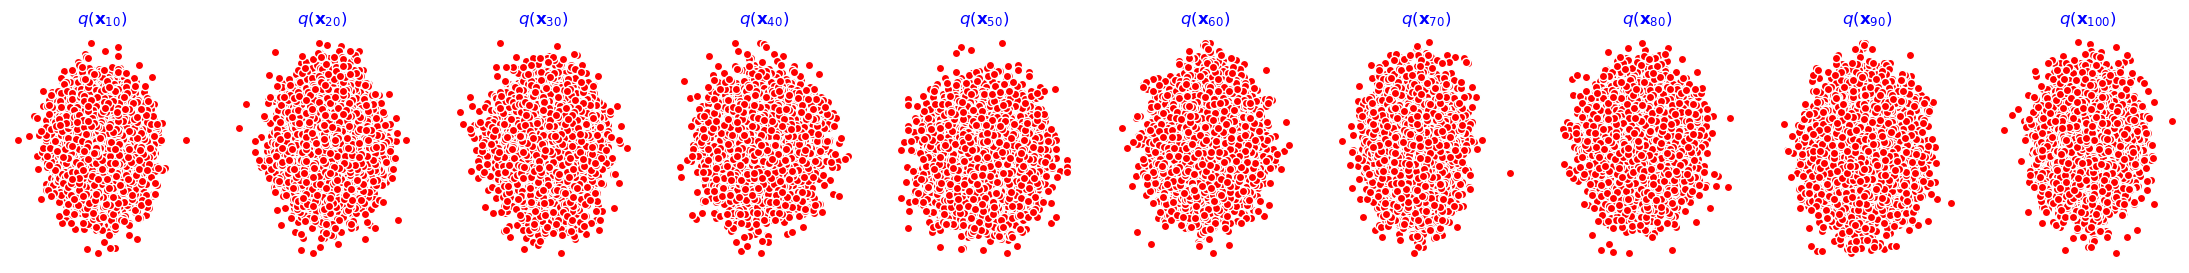

In [13]:
seed = 1234

class EMA():
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}
        
    def register(self, name, val):
        self.shadow[name] = val.clone()
    
    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print('Training model...')


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epochs = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps) # 输出维度为2， 输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epochs):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alpha_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alpha_bar_sqrt) # 共有100个元素
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], c='red',edgecolors='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')